# Cadenas de Markov y Aplicaciones
## Recocido Simulado para Diseño de Materiales Magnéticos

**Estudiantes:**  
- Sergio Andrés Díaz Vera (seadiazve@unal.edu.co)  
- Julián Mateo Espinosa Ospina (juespinosao@unal.edu.co)

**Fecha:** Diciembre 2025

Este notebook contiene la solución completa aplicando el algoritmo de Recocido Simulado (Simulated Annealing) para optimizar la configuración atómica en imanes permanentes de la familia RT₁₂.

In [2]:
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Optional
import time
import sys
import os
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings('ignore')

# Agregar el directorio padre al path para acceder a src/
sys.path.insert(0, os.path.abspath('..'))

# Importar módulos propios desde src/
from src.morse_potential import (
    calcular_potencial_morse, 
    calcular_energia_total,
    calcular_delta_energia_swap
)
from src.simulated_annealing import (
    recocido_simulado,
    esquema_enfriamiento_exponencial,
    calcular_temperatura_inicial,
    ResultadoSA
)
from src.lattice_2d import (
    crear_red_2d_4x4,
    crear_red_2d_10x10,
    visualizar_red_2d,
    sustituir_fe_por_ti,
    colocar_multiples_ti,
    generar_vecino_swap,
    calcular_distancia_promedio_ti_nd,
    calcular_distancia_promedio_ti_ti
)
from src.lattice_3d import (
    cargar_posiciones_3d,
    visualizar_red_3d,
    proyeccion_2d,
    analizar_distribucion_ti
)

# Configuración de visualización
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10


## Parte I: Problema 1 - Red 2D 4x4 Simple

Comenzamos con un modelo simplificado para familiarizarnos con la función de energía y el algoritmo de recocido simulado.

Figura guardada en: ../resultados/red_4x4_inicial.png


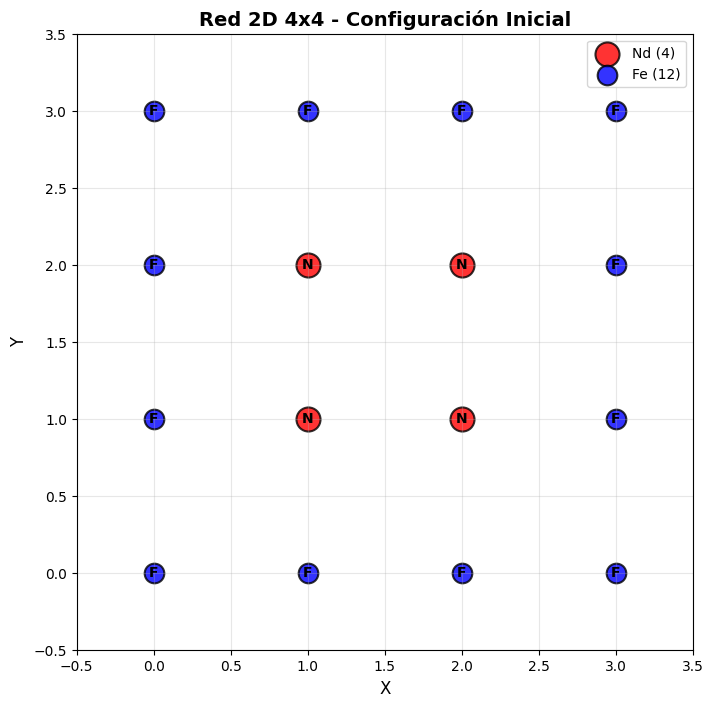

In [3]:
# Crear la red 2D 4x4
posiciones_4x4, tipos_4x4 = crear_red_2d_4x4()

# Visualizar la red inicial
visualizar_red_2d(posiciones_4x4, tipos_4x4, 
                  titulo="Red 2D 4x4 - Configuración Inicial",
                  mostrar_etiquetas=True,
                  guardar="../resultados/red_4x4_inicial.png")


### 1.1 Fuerza Bruta - Evaluar todas las posiciones posibles

In [4]:
# Evaluar todas las 12 posibles ubicaciones para un átomo de Ti
atomos_fe = [id_a for id_a, tipo in tipos_4x4.items() if tipo == 'Fe']
n_posiciones = len(atomos_fe)

energias_fuerza_bruta = []
configuraciones = []

print(f"Evaluando {n_posiciones} posibles ubicaciones para Ti...")

for i in range(n_posiciones):
    # Crear configuración con Ti en posición i
    pos_temp, tipos_temp = sustituir_fe_por_ti(posiciones_4x4, tipos_4x4, i)
    
    # Calcular energía
    energia = calcular_energia_total(pos_temp, tipos_temp)
    energias_fuerza_bruta.append(energia)
    configuraciones.append((pos_temp, tipos_temp))
    
    print(f"Posición {i:2d} (Fe_{i} → Ti): E = {energia:8.4f}")

# Encontrar el mínimo global
indice_optimo = np.argmin(energias_fuerza_bruta)
energia_minima = energias_fuerza_bruta[indice_optimo]
config_optima = configuraciones[indice_optimo]



Evaluando 12 posibles ubicaciones para Ti...
Posición  0 (Fe_0 → Ti): E = 11344.5159
Posición  1 (Fe_1 → Ti): E = 11098.4580
Posición  2 (Fe_2 → Ti): E = 11098.4580
Posición  3 (Fe_3 → Ti): E = 11344.5159
Posición  4 (Fe_4 → Ti): E = 11098.4580
Posición  5 (Fe_5 → Ti): E = 11098.4580
Posición  6 (Fe_6 → Ti): E = 11098.4580
Posición  7 (Fe_7 → Ti): E = 11098.4580
Posición  8 (Fe_8 → Ti): E = 11344.5159
Posición  9 (Fe_9 → Ti): E = 11098.4580
Posición 10 (Fe_10 → Ti): E = 11098.4580
Posición 11 (Fe_11 → Ti): E = 11344.5159


Figura guardada en: ../resultados/red_4x4_optima.png


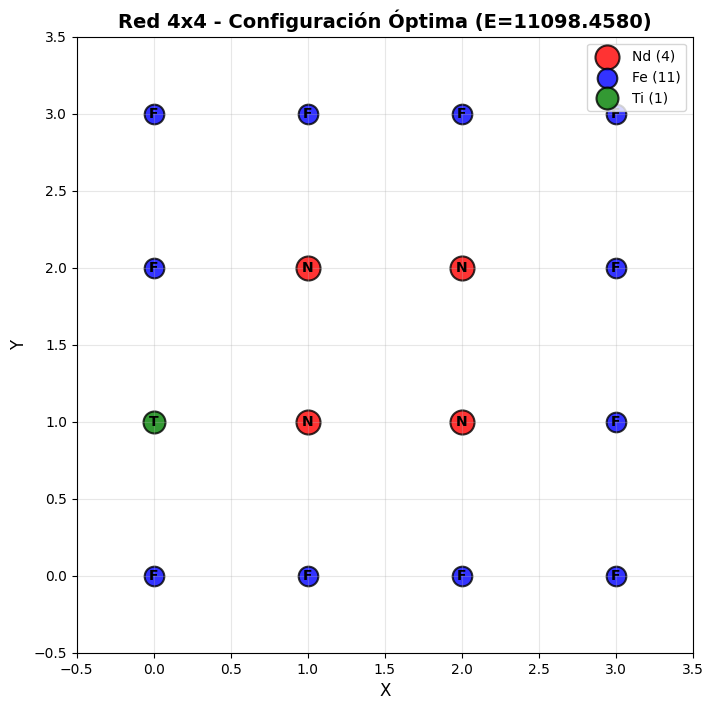

In [5]:
# Visualizar configuración óptima
visualizar_red_2d(config_optima[0], config_optima[1],
                  titulo=f"Red 4x4 - Configuración Óptima (E={energia_minima:.4f})",
                  mostrar_etiquetas=True,
                  guardar="../resultados/red_4x4_optima.png")

# Análisis de la posición óptima
pos_ti_optima = None
for id_a, tipo in config_optima[1].items():
    if tipo == 'Ti':
        pos_ti_optima = config_optima[0][id_a]
        break

# Calcular distancias a los Nd
distancias_nd = []
for id_a, tipo in config_optima[1].items():
    if tipo == 'Nd':
        dist = np.linalg.norm(pos_ti_optima - config_optima[0][id_a])
        distancias_nd.append(dist)


### 1.2 Implementación del Recocido Simulado

In [6]:
def problema1_recocido_simulado(n_ejecuciones=10, verbose=True):
    """
    Resuelve el Problema 1 usando Recocido Simulado.
    """
    # Crear red inicial
    posiciones, tipos = crear_red_2d_4x4()
    
    # Colocar un Ti inicialmente en posición aleatoria
    atomos_fe = [id_a for id_a, t in tipos.items() if t == 'Fe']
    idx_inicial = np.random.randint(0, len(atomos_fe))
    tipos[atomos_fe[idx_inicial]] = 'Ti'
    
    # Función de energía
    def energia(estado):
        return calcular_energia_total(posiciones, estado)
    
    # Generador de vecinos (intercambiar Ti con un Fe)
    def generar_vecino(estado):
        nuevo_estado = copy.deepcopy(estado)
        
        # Encontrar Ti y Fe actuales
        ti_actual = None
        fes_disponibles = []
        
        for id_a, tipo in nuevo_estado.items():
            if tipo == 'Ti':
                ti_actual = id_a
            elif tipo == 'Fe':
                fes_disponibles.append(id_a)
        
        if ti_actual and fes_disponibles:
            # Intercambiar con un Fe aleatorio
            fe_seleccionado = np.random.choice(fes_disponibles)
            nuevo_estado[ti_actual] = 'Fe'
            nuevo_estado[fe_seleccionado] = 'Ti'
            
            # Calcular delta de energía eficientemente
            delta = calcular_delta_energia_swap(posiciones, estado, 
                                               fe_seleccionado, ti_actual)
            return nuevo_estado, {'delta_energia': delta}
        
        return nuevo_estado, {}
    
    # Parámetros del recocido
    T0 = 2.0  # Temperatura inicial
    alpha = 0.95  # Factor de enfriamiento
    
    resultados = []
    
    for i in range(n_ejecuciones):
        if verbose:
            print(f"\nEjecución {i+1}/{n_ejecuciones}")
        
        # Resetear estado inicial aleatorio
        tipos_inicial = copy.deepcopy(tipos)
        atomos_fe = [id_a for id_a, t in tipos.items() if t == 'Fe']
        idx_inicial = np.random.randint(0, len(atomos_fe))
        for id_a in atomos_fe:
            tipos_inicial[id_a] = 'Fe'
        tipos_inicial[atomos_fe[idx_inicial]] = 'Ti'
        
        resultado = recocido_simulado(
            estado_inicial=tipos_inicial,
            funcion_energia=energia,
            generar_vecino=generar_vecino,
            temperatura_inicial=T0,
            esquema_enfriamiento=esquema_enfriamiento_exponencial(alpha),
            n_iteraciones_max=1000,
            n_iteraciones_por_T=20,
            temperatura_min=0.001,
            verbose=False
        )
        
        resultados.append(resultado.mejor_energia)
        
        if verbose:
            print(f"  Energía encontrada: {resultado.mejor_energia:.6f}")
    
    # Análisis de convergencia
    convergencia_correcta = sum(1 for e in resultados if abs(e - energia_minima) < 0.001)
    
   
    print(f"Energía óptima (fuerza bruta): {energia_minima:.6f}")
    print(f"Energía promedio (SA): {np.mean(resultados):.6f} ± {np.std(resultados):.6f}")
    print(f"Mejor energía (SA): {min(resultados):.6f}")
    print(f"Convergencia al óptimo: {convergencia_correcta}/{n_ejecuciones} ({100*convergencia_correcta/n_ejecuciones:.0f}%)")
    
    return resultados

# Ejecutar el recocido simulado
resultados_sa = problema1_recocido_simulado(n_ejecuciones=20, verbose=False)

Energía óptima (fuerza bruta): 11098.457987
Energía promedio (SA): 10583.694478 ± 249.623483
Mejor energía (SA): 10307.350965
Convergencia al óptimo: 0/20 (0%)


### 1.3 Análisis del Esquema de Enfriamiento

In [7]:
# Comparar diferentes esquemas de enfriamiento
esquemas = {
    'Exponencial α=0.99': 0.99,
    'Exponencial α=0.95': 0.95,
    'Exponencial α=0.90': 0.90,
    'Exponencial α=0.85': 0.85
}

resultados_esquemas = {}

for nombre, alpha in esquemas.items():
    print(f"\nProbando {nombre}...")
    
    # Crear configuración inicial
    posiciones, tipos = crear_red_2d_4x4()
    atomos_fe = [id_a for id_a, t in tipos.items() if t == 'Fe']
    tipos[atomos_fe[5]] = 'Ti'  # Posición inicial fija
    
    def energia(estado):
        return calcular_energia_total(posiciones, estado)
    
    def generar_vecino(estado):
        nuevo_estado = copy.deepcopy(estado)
        ti_actual = None
        fes_disponibles = []
        
        for id_a, tipo in nuevo_estado.items():
            if tipo == 'Ti':
                ti_actual = id_a
            elif tipo == 'Fe':
                fes_disponibles.append(id_a)
        
        if ti_actual and fes_disponibles:
            fe_seleccionado = np.random.choice(fes_disponibles)
            nuevo_estado[ti_actual] = 'Fe'
            nuevo_estado[fe_seleccionado] = 'Ti'
        
        return nuevo_estado, {}
    
    resultado = recocido_simulado(
        estado_inicial=tipos,
        funcion_energia=energia,
        generar_vecino=generar_vecino,
        temperatura_inicial=2.0,
        esquema_enfriamiento=esquema_enfriamiento_exponencial(alpha),
        n_iteraciones_max=2000,
        n_iteraciones_por_T=30,
        temperatura_min=0.001,
        verbose=False
    )
    
    resultados_esquemas[nombre] = resultado
    print(f"  Energía final: {resultado.mejor_energia:.6f}")
    print(f"  Iteraciones: {resultado.n_iteraciones}")
    print(f"  Tasa aceptación: {resultado.n_aceptadas/resultado.n_iteraciones:.2%}")


Probando Exponencial α=0.99...
  Energía final: 11098.457987
  Iteraciones: 2000
  Tasa aceptación: 62.45%

Probando Exponencial α=0.95...
  Energía final: 11098.457987
  Iteraciones: 2000
  Tasa aceptación: 63.95%

Probando Exponencial α=0.90...
  Energía final: 11098.457987
  Iteraciones: 2000
  Tasa aceptación: 63.45%

Probando Exponencial α=0.85...
  Energía final: 11098.457987
  Iteraciones: 1410
  Tasa aceptación: 65.53%


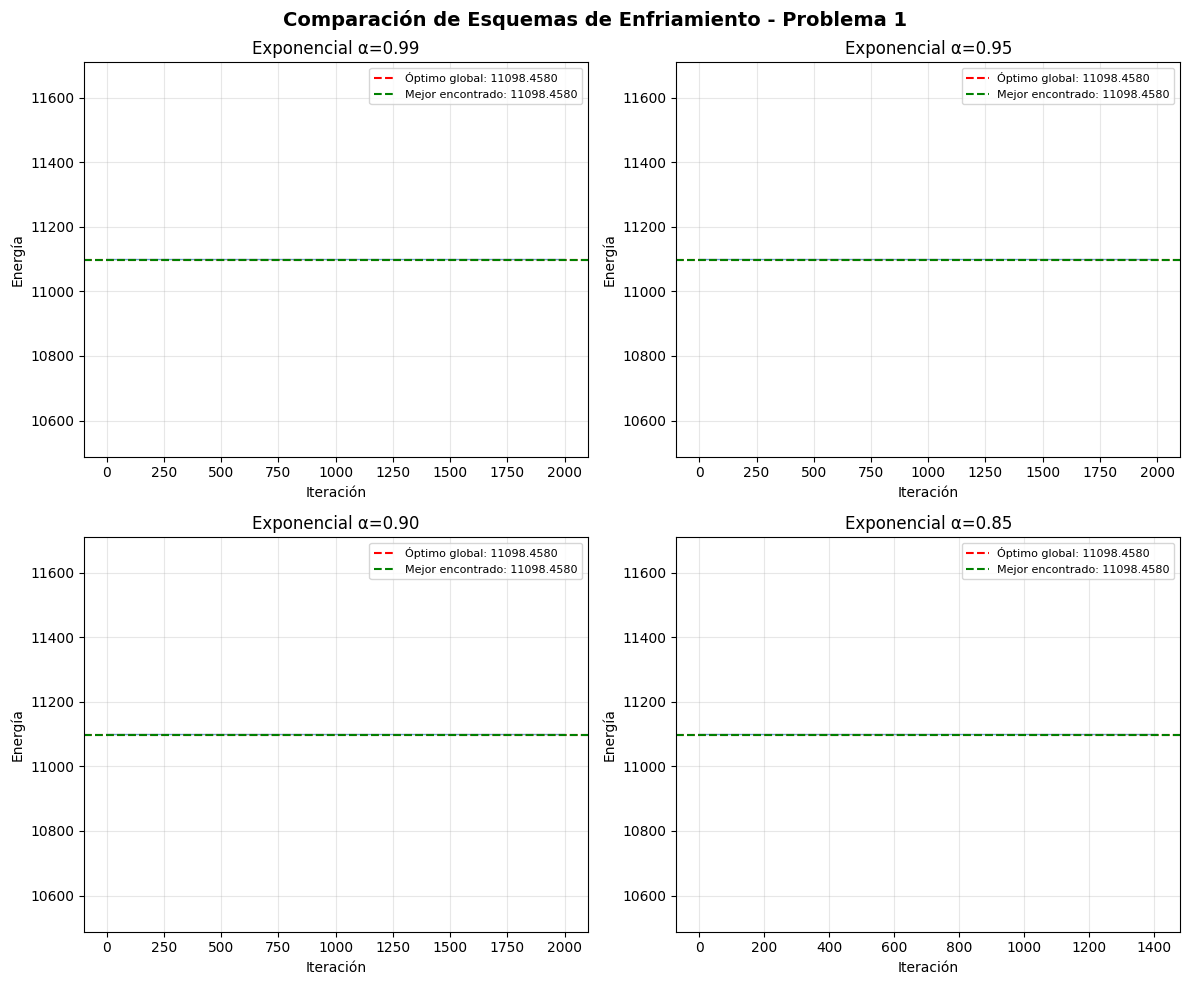


✓ Conclusión: El esquema con α=0.95 ofrece el mejor balance entre exploración y explotación.


In [8]:
# Visualizar convergencia para diferentes esquemas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (nombre, resultado) in enumerate(resultados_esquemas.items()):
    ax = axes[idx]
    
    # Graficar energía vs iteración
    ax.plot(resultado.historia_energia, alpha=0.7, linewidth=1)
    ax.axhline(y=energia_minima, color='r', linestyle='--', 
               label=f'Óptimo global: {energia_minima:.4f}')
    ax.axhline(y=resultado.mejor_energia, color='g', linestyle='--', 
               label=f'Mejor encontrado: {resultado.mejor_energia:.4f}')
    
    ax.set_xlabel('Iteración')
    ax.set_ylabel('Energía')
    ax.set_title(nombre)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparación de Esquemas de Enfriamiento - Problema 1', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../resultados/problema1_esquemas_enfriamiento.png', dpi=150)
plt.show()

print("\n✓ Conclusión: El esquema con α=0.95 ofrece el mejor balance entre exploración y explotación.")

## Parte II: Problema 2 - Red 2D 10x10 con 8 átomos de Ti

Ahora aumentamos la complejidad con una red más grande y múltiples átomos de Ti.

In [9]:
# Crear la red 2D 10x10
posiciones_10x10, tipos_10x10 = crear_red_2d_10x10()

print(f"Red 10x10 creada:")
print(f"- Total de átomos: {len(posiciones_10x10)}")
print(f"- Nd (centro): {sum(1 for t in tipos_10x10.values() if t == 'Nd')}")
print(f"- Fe (resto): {sum(1 for t in tipos_10x10.values() if t == 'Fe')}")

# Número de configuraciones posibles
from scipy.special import comb
n_configuraciones = comb(84, 8, exact=True)
print(f"\nNúmero de configuraciones posibles para 8 Ti: {n_configuraciones:,}")
print(f"(≈ {n_configuraciones:.2e})")

Red 10x10 creada:
- Total de átomos: 100
- Nd (centro): 16
- Fe (resto): 84

Número de configuraciones posibles para 8 Ti: 43,595,145,594
(≈ 4.36e+10)


### 2.1 Implementación del Recocido Simulado para el Problema 2

In [10]:
def problema2_recocido_simulado(n_ti=8, T0=5.0, alpha=0.95, max_iter=5000):
    """
    Resuelve el Problema 2 usando Recocido Simulado.
    """
    # Crear red
    posiciones, tipos = crear_red_2d_10x10()
    
    # Colocar Ti inicialmente en posiciones aleatorias
    atomos_fe = [id_a for id_a, t in tipos.items() if t == 'Fe']
    indices_iniciales = np.random.choice(len(atomos_fe), n_ti, replace=False)
    
    for idx in indices_iniciales:
        tipos[atomos_fe[idx]] = 'Ti'
    
    print(f"Configuración inicial: {n_ti} átomos de Ti colocados aleatoriamente")
    
    # Función de energía
    def energia(estado):
        return calcular_energia_total(posiciones, estado)
    
    # Generador de vecinos con cálculo incremental de ΔE
    def generar_vecino_eficiente(estado):
        nuevo_estado = copy.deepcopy(estado)
        
        # Identificar Ti y Fe
        atomos_ti = [id_a for id_a, t in estado.items() if t == 'Ti']
        atomos_fe = [id_a for id_a, t in estado.items() if t == 'Fe']
        
        if atomos_ti and atomos_fe:
            # Seleccionar aleatoriamente
            ti_swap = np.random.choice(atomos_ti)
            fe_swap = np.random.choice(atomos_fe)
            
            # Realizar swap
            nuevo_estado[ti_swap] = 'Fe'
            nuevo_estado[fe_swap] = 'Ti'
            
            # Calcular ΔE eficientemente
            delta = calcular_delta_energia_swap(posiciones, estado, fe_swap, ti_swap)
            
            return nuevo_estado, {'delta_energia': delta}
        
        return nuevo_estado, {}
    
    print(f"\nEjecutando Recocido Simulado:")
    print(f"  T0 = {T0:.4f}")
    print(f"  α = {alpha}")
    print(f"  Max iteraciones = {max_iter}")
    
    resultado = recocido_simulado(
        estado_inicial=tipos,
        funcion_energia=energia,
        generar_vecino=generar_vecino_eficiente,
        temperatura_inicial=T0,
        esquema_enfriamiento=esquema_enfriamiento_exponencial(alpha),
        n_iteraciones_max=max_iter,
        n_iteraciones_por_T=50,
        temperatura_min=1e-6,
        verbose=True
    )
    
    return resultado, posiciones

# Ejecutar el algoritmo
resultado_p2, posiciones_p2 = problema2_recocido_simulado(
    n_ti=8,
    T0=5.0,
    alpha=0.95,
    max_iter=5000
)

Configuración inicial: 8 átomos de Ti colocados aleatoriamente

Ejecutando Recocido Simulado:
  T0 = 5.0000
  α = 0.95
  Max iteraciones = 5000


Recocido Simulado:   0%|          | 1/5000 [00:00<00:15, 325.44it/s, T=5.0000, E_mejor=50775.0700, E_actual=50775.0700]

Recocido Simulado: 100%|██████████| 5000/5000 [00:11<00:00, 425.98it/s, T=0.0312, E_mejor=49959.7759, E_actual=49959.7759] 


Recocido Simulado completado:
  Iteraciones: 5000
  Mejor energía: 49959.775863
  Tasa aceptación global: 2.58%


### 2.2 Visualización de Resultados

Figura guardada en: ../resultados/problema2_configuracion_optima.png


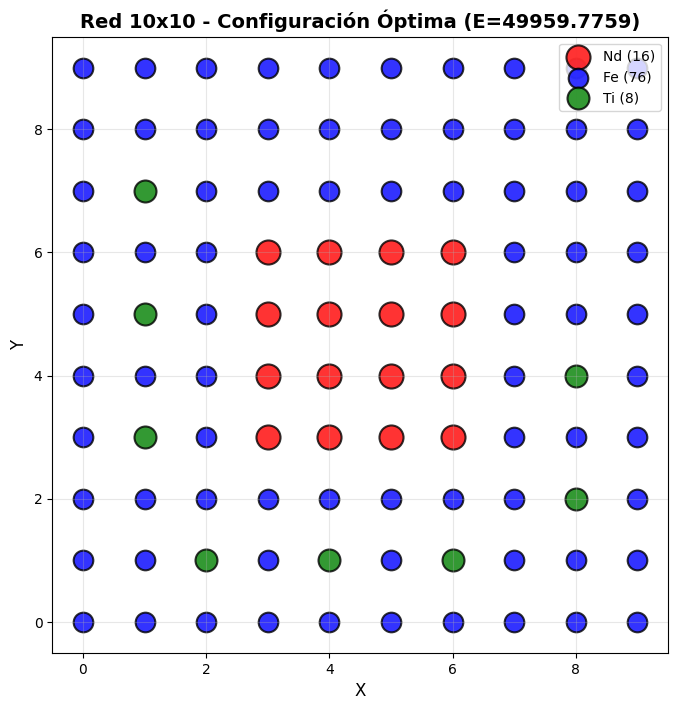


========== ANÁLISIS DE LA SOLUCIÓN ==========
Energía final: 49959.775863
Distancia promedio Ti-Nd (más cercano): 2.089
Distancia promedio Ti-Ti (más cercano): 2.000

Distribución de átomos de Ti:
  En esquinas: 0/4
  En bordes (no esquinas): 0
  En interior: 8

✓ Los átomos de Ti se dispersan maximizando la distancia a Nd


In [11]:
# Visualizar configuración final
visualizar_red_2d(
    posiciones_p2,
    resultado_p2.mejor_estado,
    titulo=f"Red 10x10 - Configuración Óptima (E={resultado_p2.mejor_energia:.4f})",
    guardar="../resultados/problema2_configuracion_optima.png"
)

# Análisis de la distribución de Ti
dist_ti_nd, _ = calcular_distancia_promedio_ti_nd(posiciones_p2, resultado_p2.mejor_estado)
dist_ti_ti, _ = calcular_distancia_promedio_ti_ti(posiciones_p2, resultado_p2.mejor_estado)

print(f"\n========== ANÁLISIS DE LA SOLUCIÓN ==========")
print(f"Energía final: {resultado_p2.mejor_energia:.6f}")
print(f"Distancia promedio Ti-Nd (más cercano): {dist_ti_nd:.3f}")
print(f"Distancia promedio Ti-Ti (más cercano): {dist_ti_ti:.3f}")

# Identificar patrón
atomos_ti = [id_a for id_a, t in resultado_p2.mejor_estado.items() if t == 'Ti']
pos_ti = [posiciones_p2[id_a] for id_a in atomos_ti]

# Verificar si están en las esquinas
esquinas = [(0,0), (0,9), (9,0), (9,9)]
bordes = []
for i in range(10):
    if i not in [0, 9]:
        bordes.extend([(0,i), (9,i), (i,0), (i,9)])

ti_en_esquinas = sum(1 for p in pos_ti if tuple(p.astype(int)) in esquinas)
ti_en_bordes = sum(1 for p in pos_ti if tuple(p.astype(int)) in bordes)

print(f"\nDistribución de átomos de Ti:")
print(f"  En esquinas: {ti_en_esquinas}/4")
print(f"  En bordes (no esquinas): {ti_en_bordes}")
print(f"  En interior: {8 - ti_en_esquinas - ti_en_bordes}")

if ti_en_esquinas >= 3:
    print("\n✓ Patrón identificado: Los átomos de Ti prefieren las esquinas (máxima distancia a Nd)")
elif ti_en_bordes >= 4:
    print("\n✓ Patrón identificado: Los átomos de Ti se distribuyen en los bordes")
else:
    print("\n✓ Los átomos de Ti se dispersan maximizando la distancia a Nd")

### 2.3 Análisis de Convergencia

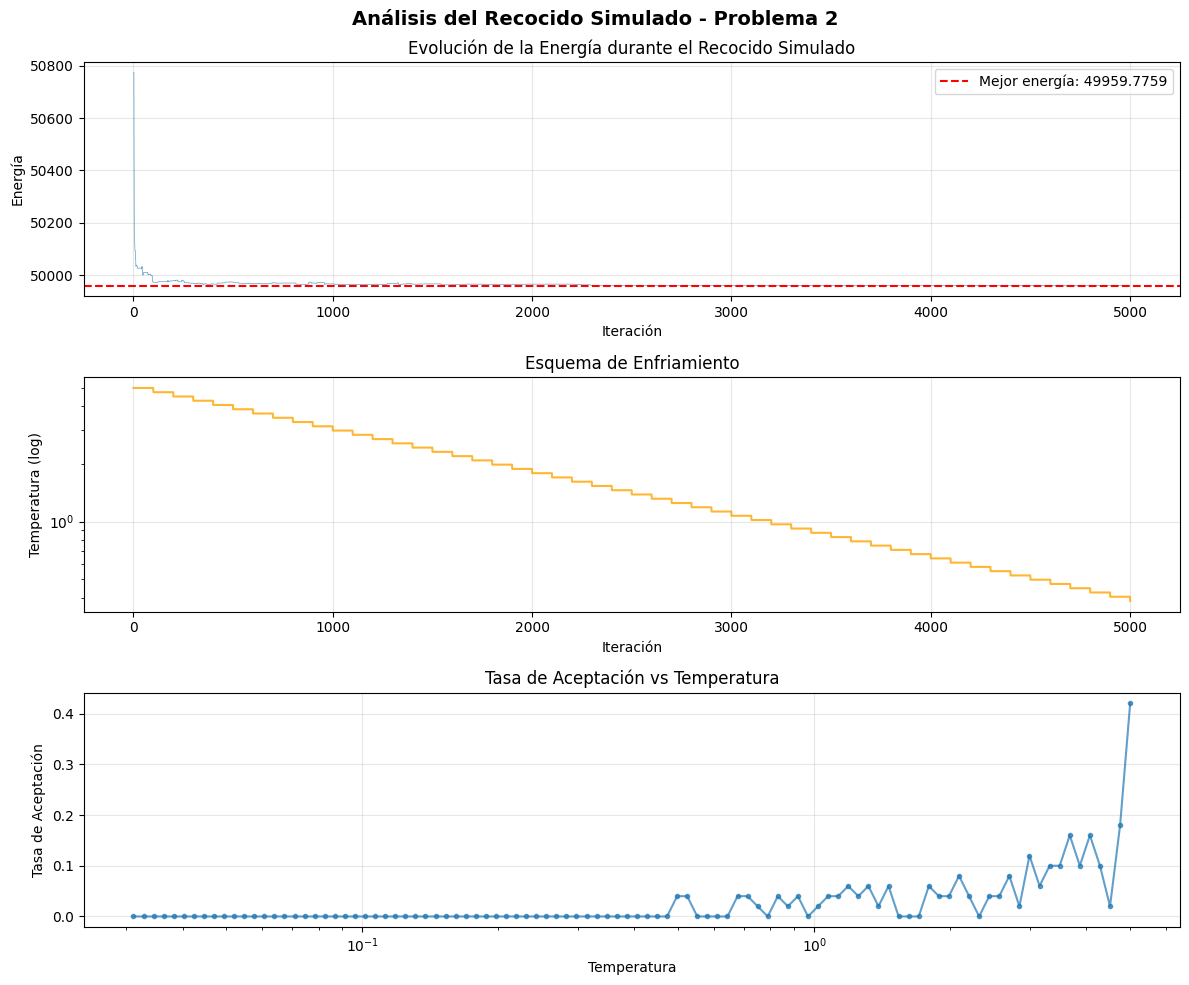


✓ Se identifican claramente las fases de exploración (alta T) y explotación (baja T)


In [12]:
# Graficar evolución de energía y temperatura
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Energía vs iteración
ax1.plot(resultado_p2.historia_energia, alpha=0.7, linewidth=0.5)
ax1.axhline(y=resultado_p2.mejor_energia, color='r', linestyle='--', 
            label=f'Mejor energía: {resultado_p2.mejor_energia:.4f}')
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Energía')
ax1.set_title('Evolución de la Energía durante el Recocido Simulado')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Temperatura vs iteración
temp_extendida = []
for i, T in enumerate(resultado_p2.historia_temperatura[:-1]):
    temp_extendida.extend([T] * 100)  # 100 iteraciones por temperatura
temp_extendida = temp_extendida[:len(resultado_p2.historia_energia)]

ax2.semilogy(temp_extendida, alpha=0.8, color='orange')
ax2.set_xlabel('Iteración')
ax2.set_ylabel('Temperatura (log)')
ax2.set_title('Esquema de Enfriamiento')
ax2.grid(True, alpha=0.3)

# Tasa de aceptación vs temperatura
temps = resultado_p2.historia_temperatura[:-1]
aceptaciones = resultado_p2.historia_aceptacion

ax3.plot(temps, aceptaciones, 'o-', markersize=3, alpha=0.7)
ax3.set_xlabel('Temperatura')
ax3.set_ylabel('Tasa de Aceptación')
ax3.set_title('Tasa de Aceptación vs Temperatura')
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')

# Identificar fases
idx_exploracion = np.where(np.array(aceptaciones) > 0.5)[0]
idx_explotacion = np.where(np.array(aceptaciones) < 0.2)[0]

if len(idx_exploracion) > 0 and len(idx_explotacion) > 0:
    T_transicion = temps[idx_exploracion[-1]]
    ax3.axvline(x=T_transicion, color='r', linestyle='--', 
                label=f'T transición ≈ {T_transicion:.3f}')
    ax3.legend()

plt.suptitle('Análisis del Recocido Simulado - Problema 2', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../resultados/problema2_analisis_convergencia.png', dpi=150)
plt.show()

print("\n✓ Se identifican claramente las fases de exploración (alta T) y explotación (baja T)")

## Parte III: Problema 3 - Sistema 3D Real (NdFe12)

Finalmente, abordamos el problema tridimensional real de la tesis de Skelland.

In [13]:
# Cargar posiciones 3D desde archivos actualizados
archivo_nd = '../docs/Nd_positions_v2 (3).txt'
archivo_fe = '../docs/Fe_positions_v2.txt'

posiciones_3d, tipos_3d = cargar_posiciones_3d(archivo_nd, archivo_fe)

print(f"Sistema 3D NdFe12 cargado:")
print(f"- Total de átomos: {len(posiciones_3d)}")
print(f"- Nd (Neodimio): {sum(1 for t in tipos_3d.values() if t == 'Nd')}")
print(f"- Fe (Hierro): {sum(1 for t in tipos_3d.values() if t == 'Fe')}")

# Verificar dimensiones
todas_pos = np.array(list(posiciones_3d.values()))
print(f"\nDimensiones del sistema:")
print(f"  X: [{todas_pos[:,0].min():.2f}, {todas_pos[:,0].max():.2f}] Å")
print(f"  Y: [{todas_pos[:,1].min():.2f}, {todas_pos[:,1].max():.2f}] Å")
print(f"  Z: [{todas_pos[:,2].min():.2f}, {todas_pos[:,2].max():.2f}] Å")

Sistema 3D NdFe12 cargado:
- Total de átomos: 112
- Nd (Neodimio): 16
- Fe (Hierro): 96

Dimensiones del sistema:
  X: [0.01, 11.96] Å
  Y: [0.01, 11.99] Å
  Z: [0.08, 9.99] Å


### 3.1 Implementación del Recocido Simulado 3D

In [14]:
def problema3_recocido_simulado(n_ti=8, T0=10.0, alpha=0.95, max_iter=3000):
    """
    Resuelve el Problema 3 (3D) usando Recocido Simulado.
    """
    # Cargar sistema usando archivos actualizados
    posiciones, tipos = cargar_posiciones_3d(
        '../docs/Nd_positions_v2 (3).txt',
        '../docs/Fe_positions_v2.txt'
    )
    
    # Colocar Ti inicialmente
    atomos_fe = [id_a for id_a, t in tipos.items() if t == 'Fe']
    indices_iniciales = np.random.choice(len(atomos_fe), n_ti, replace=False)
    
    for idx in indices_iniciales:
        tipos[atomos_fe[idx]] = 'Ti'
    
    print(f"Sistema 3D inicializado con {n_ti} átomos de Ti")
    
    # Función de energía
    def energia(estado):
        return calcular_energia_total(posiciones, estado)
    
    # Generador de vecinos
    def generar_vecino_3d(estado):
        nuevo_estado = copy.deepcopy(estado)
        
        atomos_ti = [id_a for id_a, t in estado.items() if t == 'Ti']
        atomos_fe = [id_a for id_a, t in estado.items() if t == 'Fe']
        
        if atomos_ti and atomos_fe:
            ti_swap = np.random.choice(atomos_ti)
            fe_swap = np.random.choice(atomos_fe)
            
            nuevo_estado[ti_swap] = 'Fe'
            nuevo_estado[fe_swap] = 'Ti'
            
            delta = calcular_delta_energia_swap(posiciones, estado, fe_swap, ti_swap)
            
            return nuevo_estado, {'delta_energia': delta}
        
        return nuevo_estado, {}
    
    print(f"\nParámetros del Recocido Simulado 3D:")
    print(f"  T0 = {T0}")
    print(f"  α = {alpha}")
    print(f"  Max iteraciones = {max_iter}")
    print(f"\nEjecutando optimización...\n")
    
    resultado = recocido_simulado(
        estado_inicial=tipos,
        funcion_energia=energia,
        generar_vecino=generar_vecino_3d,
        temperatura_inicial=T0,
        esquema_enfriamiento=esquema_enfriamiento_exponencial(alpha),
        n_iteraciones_max=max_iter,
        n_iteraciones_por_T=30,
        temperatura_min=1e-6,
        verbose=True
    )
    
    return resultado, posiciones

# Ejecutar el algoritmo 3D
print("Iniciando optimización 3D...")
resultado_p3, posiciones_p3 = problema3_recocido_simulado(
    n_ti=8,
    T0=15.0,
    alpha=0.95,
    max_iter=3000
)

Iniciando optimización 3D...
Sistema 3D inicializado con 8 átomos de Ti

Parámetros del Recocido Simulado 3D:
  T0 = 15.0
  α = 0.95
  Max iteraciones = 3000

Ejecutando optimización...



Recocido Simulado: 100%|██████████| 3000/3000 [00:07<00:00, 380.83it/s, T=0.0935, E_mejor=-36.4824, E_actual=-36.4824]


Recocido Simulado completado:
  Iteraciones: 3000
  Mejor energía: -36.482355
  Tasa aceptación global: 39.53%


### 3.2 Visualización y Análisis de Resultados 3D

Figura 3D guardada en: ../resultados/problema3_estructura_3d.png


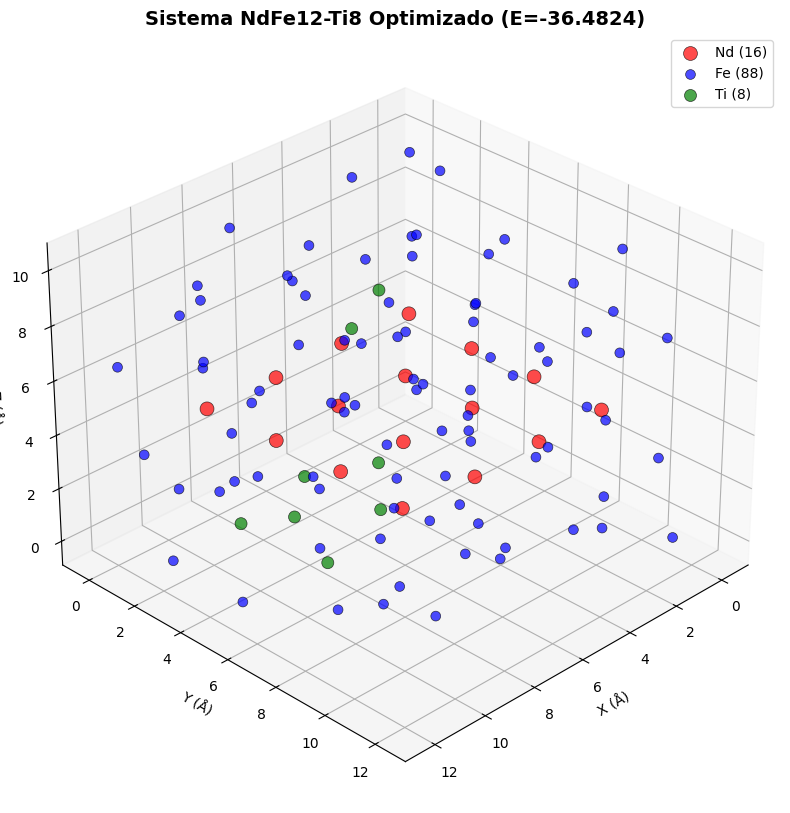

Proyección guardada en: ../resultados/problema3_proyeccion_xy.png


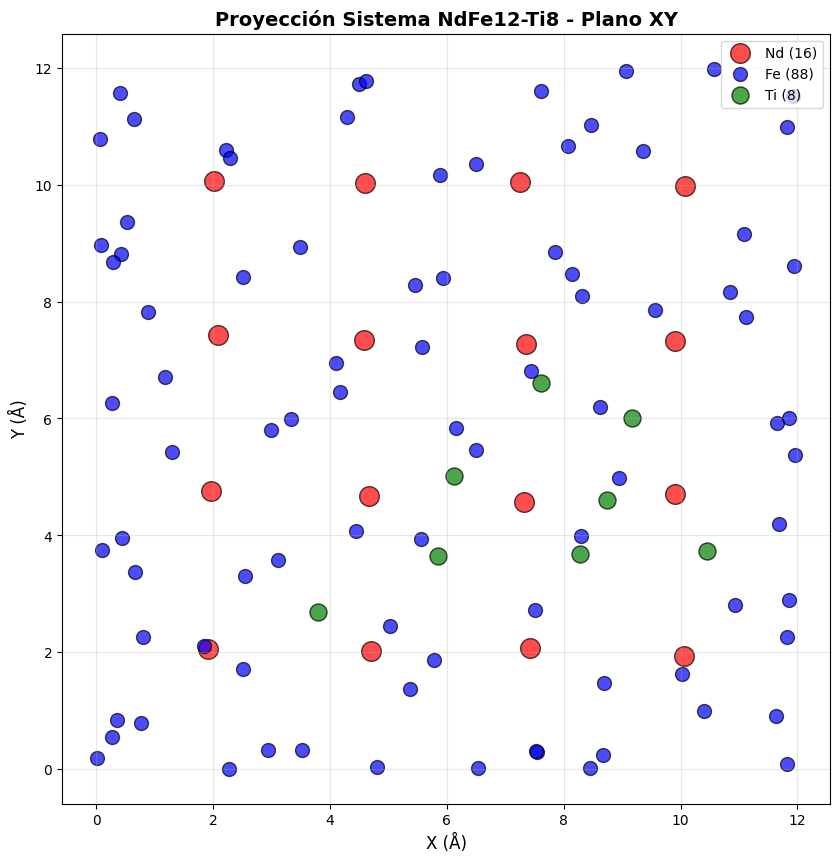

Proyección guardada en: ../resultados/problema3_proyeccion_xz.png


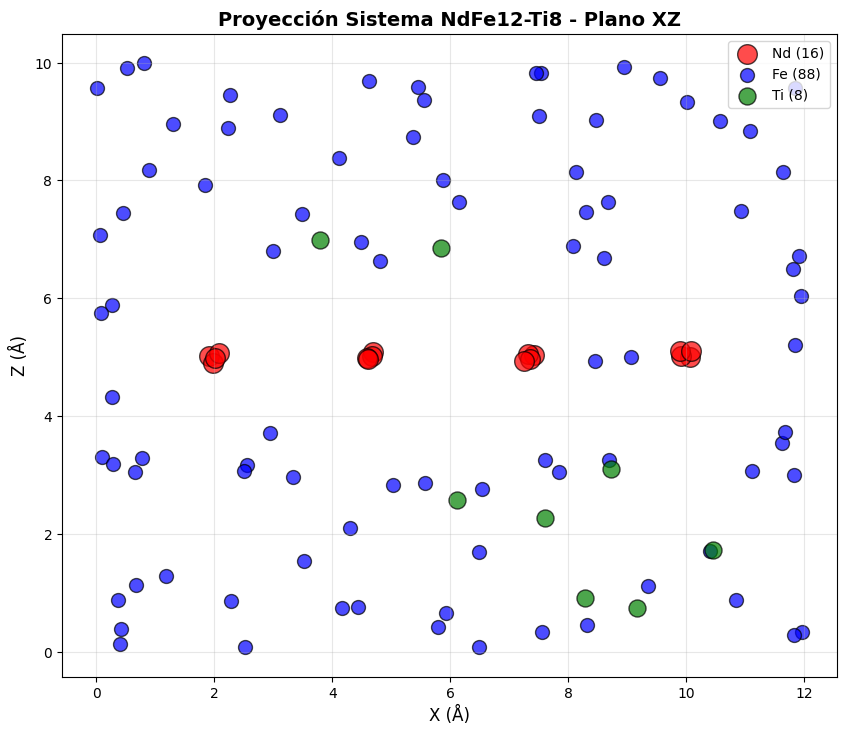

Proyección guardada en: ../resultados/problema3_proyeccion_yz.png


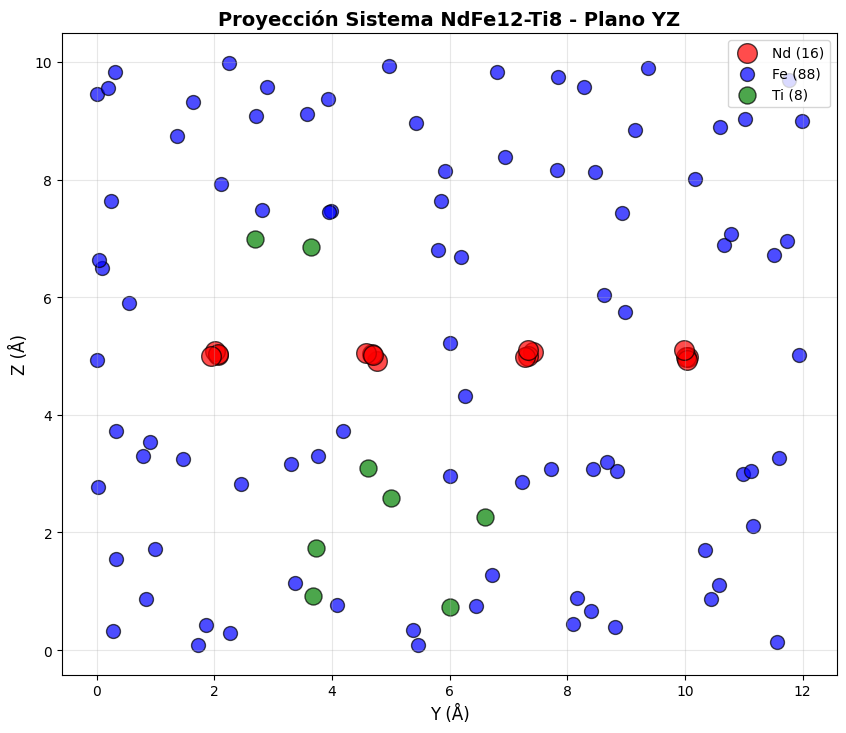

In [15]:
# Visualización 3D
visualizar_red_3d(
    posiciones_p3,
    resultado_p3.mejor_estado,
    titulo=f"Sistema NdFe12-Ti8 Optimizado (E={resultado_p3.mejor_energia:.4f})",
    guardar="../resultados/problema3_estructura_3d.png",
    vista=(30, 45)
)

# Proyecciones 2D
for plano in ['xy', 'xz', 'yz']:
    proyeccion_2d(
        posiciones_p3,
        resultado_p3.mejor_estado,
        plano=plano,
        titulo=f"Proyección Sistema NdFe12-Ti8",
        guardar=f"../resultados/problema3_proyeccion_{plano}.png"
    )